# Train Models

Script to train and save models (to be used in Docker Container)

In [1]:
from datetime import datetime,timedelta
from forecaster import Predictor_Load, Predictor_PV

import os
from pathlib import Path
import matplotlib.pyplot as plt

config_file =  Path(os.getcwd()).parent.parent.joinpath(f"config.ini")



## Create Load Forecaster

- Output Window = 1 Day

In [2]:
load_pred = Predictor_Load(input_window = 4 * 24,
                           output_window= 4 * 24,
                           days_of_data=100,
                           config_file_path=config_file)


INFO:root:Create LOAD Predictor
INFO:root:Creating TCN Model
INFO:root:selected 8 tcn layers with receptive field of 128
INFO:root:Created 1 Input Streams of Size KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[None, 96, 1], name='tf.compat.v1.shape/Shape:0', description="created by layer 'tf.compat.v1.shape'")


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 96, 1)]      0           []                               
                                                                                                  
 tf.split (TFOpLambda)          [(None, 96, 1)]      0           ['inputs[0][0]']                 
                                                                                                  
 Conv_1D_D0_L00_1 (Conv1D)      (None, 96, 12)       24          ['tf.split[0][0]']               
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 96, 12)      0           ['Conv_1D_D0_L00_1[0][0]']       
 out1D)                                                                                       

INFO:root:	 Loaded 9526 values for key Total Load
INFO:root:	 Merged all Values into Dataset whith shape (9526, 1)
INFO:root:Created 9334 slices of data
INFO:root:Created Train, Val, Test Samples of Size:       [5748, 2433, 5]
INFO:root:This is an actual train,val,test split ratio of [0.702, 0.999, 1.0]
INFO:root:Shuffled all Datasets
INFO:root:------ Finished Data preprocessing ------
INFO:root:Created Dataset have the following Shapes:
INFO:root:	 x_train : (5748, 96, 1)
INFO:root:	 y_train : (5748, 96, 1)
INFO:root:	 x_val   : (2433, 96, 1)
INFO:root:	 y_val   : (2433, 96, 1)
INFO:root:	 x_test  : (5, 96, 1)
INFO:root:	 y_test  : (5, 96, 1)


In [38]:
load_pred.train(epochs = 3)

INFO:root:Start Model Training


Epoch 1/3
5748/5748 [==============================] - 37s 7ms/step - loss: 32.3347 - mae: 4.4438 - val_loss: 37.8943 - val_mae: 4.8216
Epoch 2/3
5748/5748 [==============================] - 37s 7ms/step - loss: 31.1967 - mae: 4.3637 - val_loss: 36.4047 - val_mae: 4.7226
Epoch 3/3
5748/5748 [==============================] - 38s 7ms/step - loss: 30.2209 - mae: 4.2950 - val_loss: 35.1159 - val_mae: 4.6299


INFO:root:Smallest loss: 30.220918655395508
INFO:root:Smallest mae: 4.29500150680542
INFO:root:Smallest val_loss: 35.11587905883789
INFO:root:Smallest val_mae: 4.62988805770874


# PV Forecaster

In [ ]:
pv_pred = Predictor_PV(input_window= 4 * 24,
                       output_window= 4 * 24,
                       days_of_data=30,
                       config_file_path=config_file)

### Load a Model (if needed)

In [ ]:
pv_pred.load_model(f"model_pv_2024-08-16")

In [ ]:
#pv_pred.train(epochs = 20)
pv_pred.train(epochs = 100, steps_per_epoch = 100, val_steps = 50)

# Analyze Load Model

INFO:root:Predicting ONE TEST Sample: [2]


1/1 [==============================] - 0s 21ms/step


INFO:root:Can only yet post process PV Predictions -> returning original Data


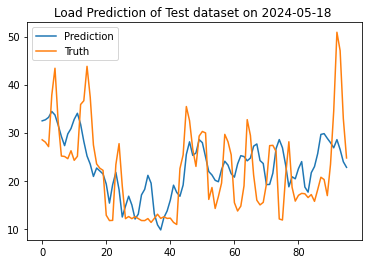

In [40]:
sample_nr = 2

dataset = "Test"

pred = load_pred.predict_sample(sample_nr=sample_nr, dataset_kind=dataset, log_pred=False)
pred = pred.reshape((pred.shape[1],pred.shape[0]))

y_pred = load_pred.dataset.de_normalize(pred)

end_time = load_pred.dataset.train_times[sample_nr]
y_true = load_pred.dataset.y_train[sample_nr]

if dataset == "Val":
    end_time = load_pred.dataset.val_times[sample_nr]
    y_true = load_pred.dataset.y_val[sample_nr]

if dataset == "Test":
    end_time = load_pred.dataset.test_times[sample_nr]
    y_true = load_pred.dataset.y_test[sample_nr]


y_true = load_pred.dataset.de_normalize(y_true)

plt.title(f"Load Prediction of {dataset} dataset on {end_time.date()} ")
plt.plot(y_pred, label = "Prediction")
plt.plot(y_true, label = "Truth")
plt.legend()
plt.show()

In [37]:
_ = load_pred.test()

1/1 [==============================] - 0s 22ms/step


INFO:root:Predictor has an Mean Absolute Test Error of 5.4868


In [35]:
load_pred.model.save(f"model_load_{datetime.today().date()}")

INFO:tensorflow:Assets written to: model_load_2024-08-17\assets


INFO:tensorflow:Assets written to: model_load_2024-08-17\assets


### Analyze Data

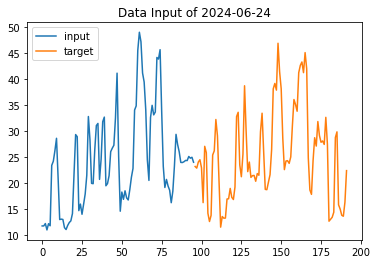

In [44]:
sample = 16

x = load_pred.dataset.x_train[sample,:,:]
y = load_pred.dataset.y_train[sample,:]
end_time = load_pred.dataset.train_times[sample]

start_x = end_time - timedelta(hours = load_pred.input_window / 4)
end_x = end_time
start_y = end_time + timedelta(minutes=15)
end_y = start_y + timedelta(hours = load_pred.output_window / 4)

x_idx = list(range(0,len(x)))
y_idx = list(range(len(x),len(y)+len(x)))


plt.title(f"Data Input of {end_time.date()}")
plt.plot(x_idx,x[:,0], label = "input")
plt.plot(y_idx,y,label = "target")
plt.legend()
plt.show()

INFO:root:Predicting ONE TRAIN Sample: [0]


1/1 [==============================] - 0s 23ms/step


INFO:root:Can only yet post process PV Predictions -> returning original Data


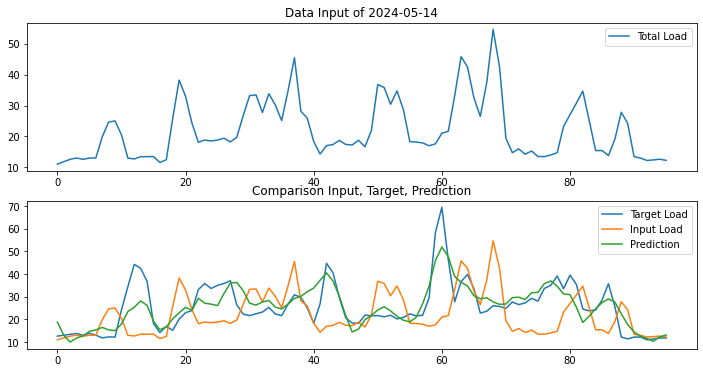

In [46]:
sample = 0

x = load_pred.dataset.x_train[sample,:,:]
y = load_pred.dataset.y_train[sample,:]
end_time = load_pred.dataset.train_times[sample]

# also add prediction
pred = load_pred.predict_sample(sample_nr=sample, dataset_kind="Train", log_pred=False)
pred = pred.reshape((pred.shape[1],pred.shape[0]))
y_pred = load_pred.dataset.de_normalize(pred)

start_x = end_time - timedelta(hours = load_pred.input_window / 4)
end_x = end_time
start_y = end_time + timedelta(minutes=15)
end_y = start_y + timedelta(hours = load_pred.output_window / 4)

x_idx = list(range(0,len(x)))
y_idx = list(range(0,len(y)))

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.title(f"Data Input of {end_time.date()}")
plt.plot(x_idx,x, label = list(load_pred.input_keys.keys())[0])
plt.legend()
plt.subplot(2,1,2)
plt.title("Comparison Input, Target, Prediction")
plt.plot(y_idx,y,label = "Target Load")
plt.plot(y_idx,x,label = "Input Load")
plt.plot(y_idx,y_pred, label = "Prediction")
plt.legend()
plt.show()

### unseen data

INFO:root:Start a new prediction with data between [2024-08-01 ... 2024-08-02]
INFO:root:Starting with getting new data between [2024-08-01 ... 2024-08-02]
INFO:root:	 Loaded 96 values for key Total Load
INFO:root:	 Merged all Values into Dataset whith shape (96, 1)
INFO:root:Got new Data of Shape (1, 96, 1)


1/1 [==============================] - 0s 30ms/step


INFO:root:Got new predictions of shape (1, 96)
INFO:root:Can only yet post process PV Predictions -> returning original Data
INFO:root:Logging new prediction sample 0 from 2024-08-02 to Total Load in pred bucket of DB


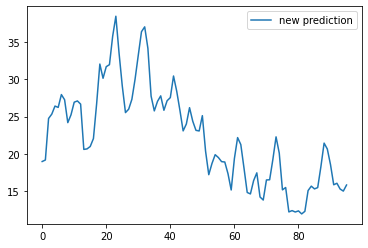

In [51]:
pred_date = datetime.now() - timedelta(days = 15, hours=1)

y_pred = load_pred.predict_new(end_date=pred_date, horizon=timedelta(days=1),log_pred=True)

y_pred = y_pred.reshape(96,)

plt.plot(y_pred,label = "new prediction")
plt.legend()
plt.show()

# Analyze PV Model

In [ ]:
sample_nr = 0

dataset_kind = "Train"

y_pred = pv_pred.predict_sample(sample_nr=sample_nr, dataset_kind=dataset_kind, log_pred=False)
y_pred = y_pred.reshape((y_pred.shape[1],y_pred.shape[0]))

# y_pred = pv_pred.dataset.de_normalize(pred)

times_data = pv_pred.dataset.train_times[sample_nr]
y_true = pv_pred.dataset.y_train[sample_nr]
if dataset_kind == "Test":
    times_data = pv_pred.dataset.test_times[sample_nr]
    y_true = pv_pred.dataset.y_test[sample_nr]
elif dataset_kind == "Val":
    times_data =pv_pred.dataset.val_times[sample_nr]
    y_true = pv_pred.dataset.y_val[sample_nr]

y_true = pv_pred.dataset.de_normalize(y_true)

forecast_time = times_data + timedelta(minutes=15 * pv_pred.output_window)

sample_time = forecast_time.date() 


plt.plot(y_pred, label = "Prediction")
plt.plot(y_true, label = "Truth")
plt.title(f"Sample from {sample_time} of {dataset_kind} dataset")

plt.legend()
plt.show()

### new unseen prediction

In [ ]:
pred_date = datetime.now() - timedelta(days = 9, hours=1)

y_pred = pv_pred.predict_new(end_date=pred_date, horizon=timedelta(days=1),log_pred=False)

y_pred = y_pred.reshape(96,)

plt.plot(y_pred,label = "new prediction")
plt.legend()
plt.show()

## Save trained model

In [ ]:
pv_pred.model.save(f"model_pv_{datetime.today().date()}_2")

# check dataset

In [ ]:
pv_pred.dataset.input_keys

In [ ]:
sample = 0

x = pv_pred.dataset.x_train[sample,:,:]
y = pv_pred.dataset.y_train[sample,:]
end_time = pv_pred.dataset.train_times[sample]

start_x = end_time - timedelta(hours = pv_pred.input_window / 4)
end_x = end_time
start_y = end_time + timedelta(minutes=15)
end_y = start_y + timedelta(hours = pv_pred.output_window / 4)

x_idx = list(range(0,len(x)))
y_idx = list(range(len(x),len(y)+len(x)))


plt.title(f"Data Input of {end_time.date()}")
plt.plot(x_idx,x[:,0], label = "input")
plt.plot(y_idx,y,label = "target")
plt.legend()
plt.show()

In [ ]:
sample = 0

x = pv_pred.dataset.x_train[sample,:,:]
y = pv_pred.dataset.y_train[sample,:]
end_time = pv_pred.dataset.train_times[sample]

start_x = end_time - timedelta(hours = pv_pred.input_window / 4)
end_x = end_time
start_y = end_time + timedelta(minutes=15)
end_y = start_y + timedelta(hours = pv_pred.output_window / 4)

x_idx = list(range(0,len(x)))
y_idx = list(range(0,len(y)))

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.title(f"Data Input of {end_time.date()}")
plt.plot(x_idx,x, label = list(pv_pred.input_keys.keys()))
plt.legend()
plt.subplot(2,1,2)
plt.title("Data Target")
plt.plot(y_idx,y,label = list(pv_pred.output_key.keys())[0])
plt.plot(y_idx,x[:,1]/10,label = list(pv_pred.input_keys.keys())[1])
plt.legend()
plt.show()